# DETR ResNet AI training model

The DETR ResNet AI training model is a state-of-the-art object detection model that combines the power of the DETR (DEtection TRansformer) architecture with the ResNet backbone. This model is designed to accurately detect and localize objects in images, making it a valuable tool for various computer vision tasks.

The DETR ResNet model leverages the transformer architecture, which has proven to be highly effective in natural language processing tasks. By adapting this architecture to the object detection domain, the model is able to capture both global and local contextual information, leading to improved detection performance.

The ResNet backbone, on the other hand, provides a strong feature extraction capability. It consists of a deep convolutional neural network that can effectively learn hierarchical representations of visual features. By combining the ResNet backbone with the DETR architecture, the model can effectively extract informative features from images and use them for accurate object detection.

Training the DETR ResNet AI model involves feeding it with a large dataset of annotated images, where each image is labeled with bounding boxes and corresponding object classes. The model then learns to predict the bounding boxes and classes of objects in unseen images by optimizing a loss function that measures the discrepancy between the predicted and ground truth annotations.

Once trained, the DETR ResNet model can be used for a variety of applications, such as object detection in autonomous driving, surveillance systems, and image analysis tasks. Its ability to accurately detect and localize objects makes it a valuable asset in the field of computer vision.

In summary, the DETR ResNet AI training model combines the power of the DETR architecture with the feature extraction capabilities of the ResNet backbone. This fusion enables accurate object detection and localization, making it a versatile tool for various computer vision tasks.

## Additional steps:
- activated virtual environment
- updated pip
- installed huggingface_hub


In [1]:
# installing prerequisites
# installing transformers and pytorth (google colab comes with transformers library)

%pip install -q transformers
%pip install -q pytorch-lightning

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Downloading and preprocessing Data
We're using a self-labeled dataset with images and bounding boxes.
Data exported in VOC XML format -> augmented using Roboflow -> exported as Coco JSON

## Creating PyTorch dataset + dataloaders
PyThon model training is usually done by creating datasets and corresponding -loaders

### Defining a PyTorch dataset
- each item is an image and corresponding annotations
- Torchvision already provides a *CocoDetection* dataset
- we add an image processor (*DetrImageProcessor*) to resize + normalize the images and change annotations from COCO format into format expected from DETR

In [2]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json" if train else "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (as said in cell before)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%pip install pycocotools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='../datasets/AnimalDataset/train', processor=processor)
val_dataset = CocoDetection(img_folder='../datasets/AnimalDataset/valid', processor=processor, train=False)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 12722
Number of validation examples: 1233


## Verifying an example by visualisation -> COCO API

Image number10507


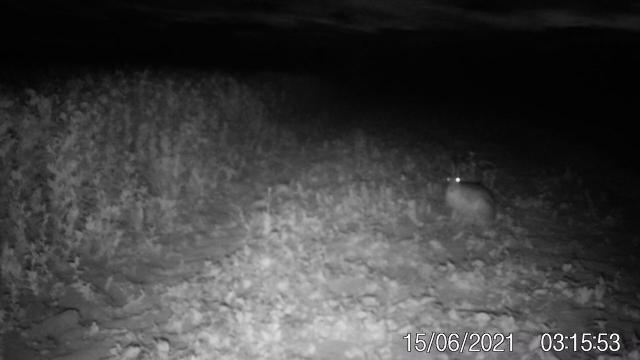

In [6]:
import numpy as np
import os
from PIL import Image, ImageDraw

# pick random training image
image_ids = train_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print("Image number{}".format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('../datasets/AnimalDataset/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k, v in cats.items()}

for ann in annotations:
    box = ann['bbox']
    class_idx = ann['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x,y), id2label[class_idx], fill='white')

image

## PyTorch dataloaders
These allow us to get batches of data.
- define custom *collate_fn* to batch imgs together
- DETR resizes imgs to have sizes of 800-1300px, we pad images *pixel_values* to largest img in a batch
    -> create corresponding *pixel_mask* to indicate with pixels are _real_ (1) or are _padding_ (0)


In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [8]:
# verify keys of a single batch:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [9]:
# verify shape of pixel_values tensor and check target:
pixel_values, target = train_dataset[0]

In [10]:
pixel_values.shape, target

(torch.Size([3, 750, 1333]),
 {'size': tensor([ 750, 1333]), 'image_id': tensor([0]), 'class_labels': tensor([11]), 'boxes': tensor([[0.4469, 0.6749, 0.3125, 0.5943]]), 'area': tensor([185663.2188]), 'iscrowd': tensor([0]), 'orig_size': tensor([360, 640])})

## Train the model using PyTorch Lightning
We define a *LightningModule*, which is a *nn.Module* with extra functionality

In [11]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
   def __init__(self, lr, lr_backbone, weight_decay):
      super().__init__()
      # replace COCO classification head with custom head
      # we specify the "no_timm" variant here to not rely on the timm library
      # for the convolutional backbone
      self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                            revision="no_timm",
                                                            num_labels=len(id2label),
                                                            ignore_mismatched_sizes=True)
      # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
      self.lr = lr
      self.lr_backbone = lr_backbone
      self.weight_decay = weight_decay

   def forward(self, pixel_values, pixel_mask):
      outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

      return outputs

   def common_step(self, batch, batch_idx):
      pixel_values = batch["pixel_values"]
      pixel_mask = batch["pixel_mask"]
      labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

      outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

      loss = outputs.loss
      loss_dict = outputs.loss_dict

      return loss, loss_dict

   def training_step(self, batch, batch_idx):
      loss, loss_dict = self.common_step(batch, batch_idx)
      # logs metrics for each training_step,
      # and the average across the epoch
      self.log("training_loss", loss)
      for k,v in loss_dict.items():
         self.log("train_" + k, v.item())

      return loss

   def validation_step(self, batch, batch_idx):
      loss, loss_dict = self.common_step(batch, batch_idx)
      self.log("validation_loss", loss)
      for k,v in loss_dict.items():
         self.log("validation_" + k, v.item())

      return loss

   def configure_optimizers(self):
      param_dicts = [
         {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
         {
            "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": self.lr_backbone,
         },
      ]
      optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

      return optimizer

   def train_dataloader(self):
      return train_dataloader

   def val_dataloader(self):
      return val_dataloader

In [27]:
# Ensure TensorBoard is installed
# %pip install tensorboard

# Load the TensorBoard extension and start TensorBoard
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

ERROR: Could not find 'C:\\Python311\\Scripts\\tensorboard.exe' (set
by the `TENSORBOARD_BINARY` environment variable). Please ensure that
your PATH contains an executable `tensorboard` program, or explicitly
specify the path to a TensorBoard binary by setting the
`TENSORBOARD_BINARY` environment variable.

In [13]:
# define model and verify outputs
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch["pixel_values"], pixel_mask=batch["pixel_mask"])

c:\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\emilp\.cache\huggingface\hub\models--facebook--detr-resnet-50. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly i

As you can see in the error message before, the labels dont match our new labels.
Our logits are of shape *(batch_size, num_queries, number of classes +1)

In [15]:
outputs.logits.shape

torch.Size([4, 100, 15])

## Finally training the model:
- we train for a max of 300 training steps, using gradient clipping

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=300, gradient_clip_val=0.1)
trainer.fit(model)